## Import Packages

In [2]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('data/full_data_flightdelay.csv')
df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


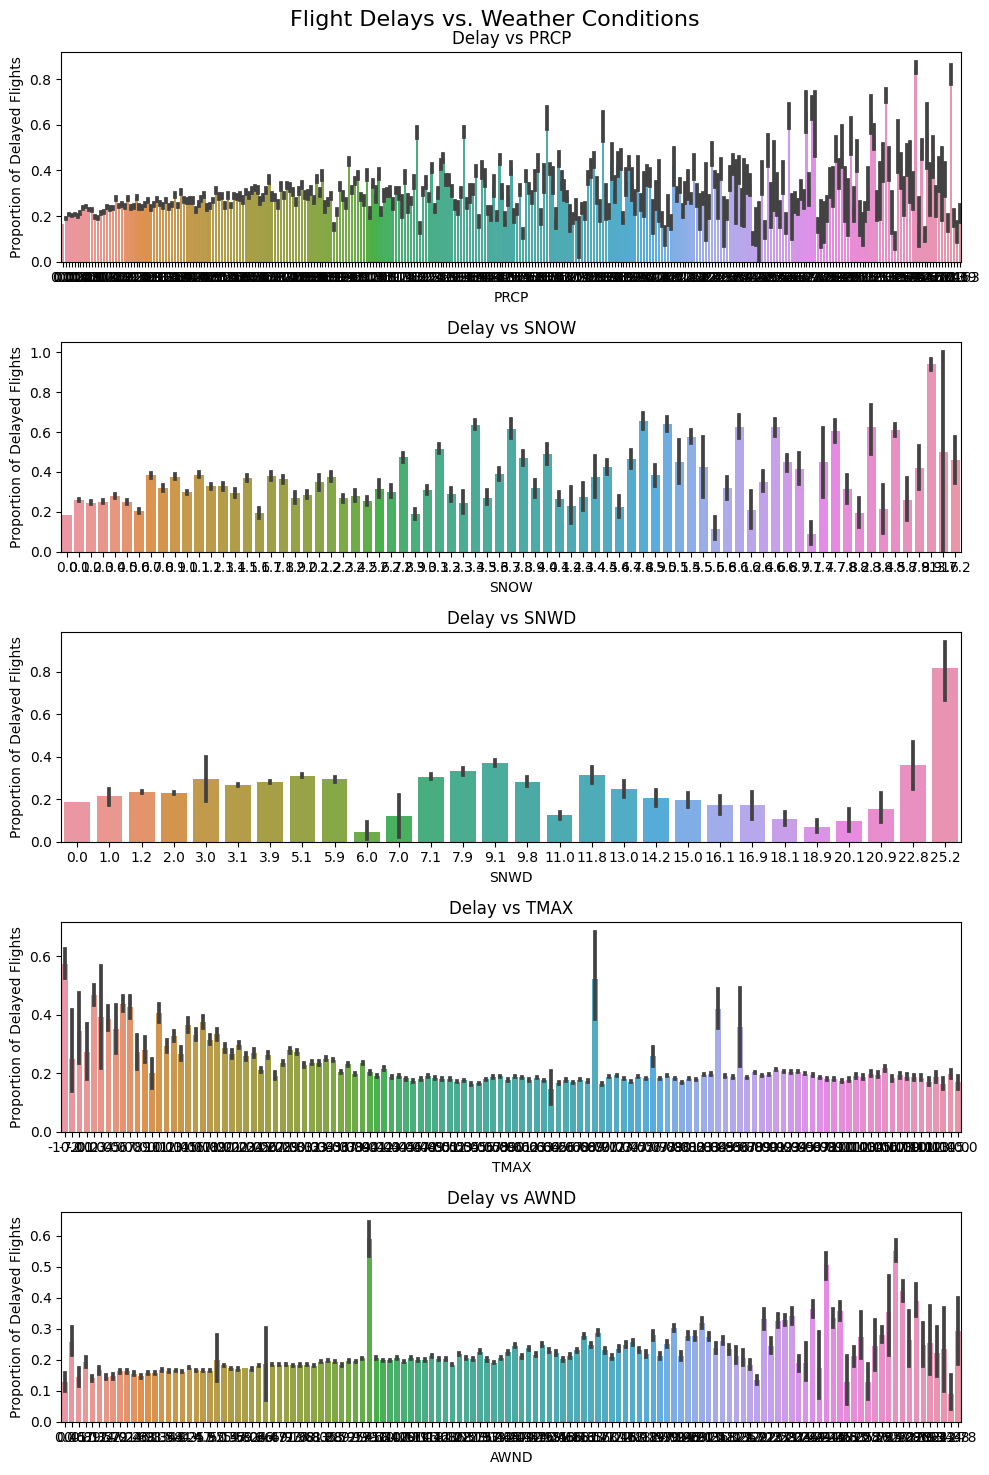

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame with delayed and not delayed flights
delayed_flights = df[df['DEP_DEL15'] == 1]
not_delayed_flights = df[df['DEP_DEL15'] == 0]

# Weather columns of interest
weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

# Create subplots for each weather condition
fig, axes = plt.subplots(nrows=len(weather_columns), ncols=1, figsize=(10, 15))
fig.suptitle('Flight Delays vs. Weather Conditions', fontsize=16)

for i, weather_column in enumerate(weather_columns):
    # Plot delayed and not delayed flights for each weather condition
    ax = axes[i]
    sns.barplot(x=weather_column, y='DEP_DEL15', data=df, ax=ax)
    ax.set_title(f'Delay vs {weather_column}')
    ax.set_xlabel(f'{weather_column}')
    ax.set_ylabel('Proportion of Delayed Flights')

plt.tight_layout()
plt.show()


## Preprocessing

In [3]:
print("Let's preprocess")

Let's preprocess


## Training

## Evaluation